# GEONE - Substitution Random Functions (SRF) - categorical random fields

A substitution random function is a function $Z=Y(T)$, where $T$ is the **directing function** (latent field) and $Y$ the **coding process**.

The directing function $T$ is a random process, $T: \mathbb{R}^d \longrightarrow  \mathbb{R}$, and the coding process a random process, $Y:\mathbb{R}\longrightarrow \mathbb{R}$.

- The directing function and the coding process are independent.
- The directing function has stationary increment.
- The coding process is stationary.

In this notebook, we consider SRF with 

- multiGaussian latent field $T$
- Markov chain on a finite set (set of given categories) as coding process $Y$

Illustrations are given for unconditional and conditional cases, in 1D, 2D, and 3D.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import matplotlib.colors
from matplotlib.gridspec import GridSpec

import pyvista as pv

# import from package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Function `geone.srf.srf_mg_mc`

This function allows to generate categorical realizations in 1D, 2D and 3D (see examples below) of SRF with multiGaussian latent field and Markov chain as coding process. Conditional and unconditional simulations can be done. For conditional simulation, a kind of Metropolis-Hasting algorithm is used (see help of the function); if conditioning fails, it is possible to get less realizations than the specified number (warning is displayed depending on the `verbose` keyword argument). Moreover, control point(s) on the coding process can be added, typically imposing the value of $Y$ at the mean of $T$.

In full output mode (keyword argument `full_output=True` (default)), in addition to the resulting $Z$ fields, are retrieved in output: the latent fields ($T$) and the Markov chains ($Y$) of all realizations.

## Example : conditional 1D SRF

In [4]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']
im_T_display={'cmap':'terrain'}
im_Z_display={'categ':True, 'categVal':categVal, 'categCol':categCol}

In [5]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 1,   1    # number of cells
sx, sy, sz = 0.5, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T (latent field)
# -------------------------------------
r_T = 15.0
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel1D(elem=[
    ('matern', {'w':w_T, 'r':gn.covModel.cov_matern_get_r_param(nu_T, r_T), 'nu':nu_T}),
    ], name='cov_model_T')

# Mean of T
mean_T = 0.0

# Markov chain Y
# --------------
# Transition kernel
p = 0.995
kernel_Y = gn.markovChain.mc_kernel1(ncat, p)  # (see function)

# 1D-grid resolution for Y (coding process)
spacing_Y = 0.001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([17.25, 27.25, 54.25, 66.25, 75.25])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)

# Additional constraint on Y (control points)
t_constraint = None
yt_constraint = None

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, nx, sx, ox,
    spacing_Y=spacing_Y,
    categVal=categVal,
    # ntry_max=100,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx, 0., 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

srf_mg_mc: simulation 1 of 3...
srf_mg_mc:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mc:   ... sim 1 of 3

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


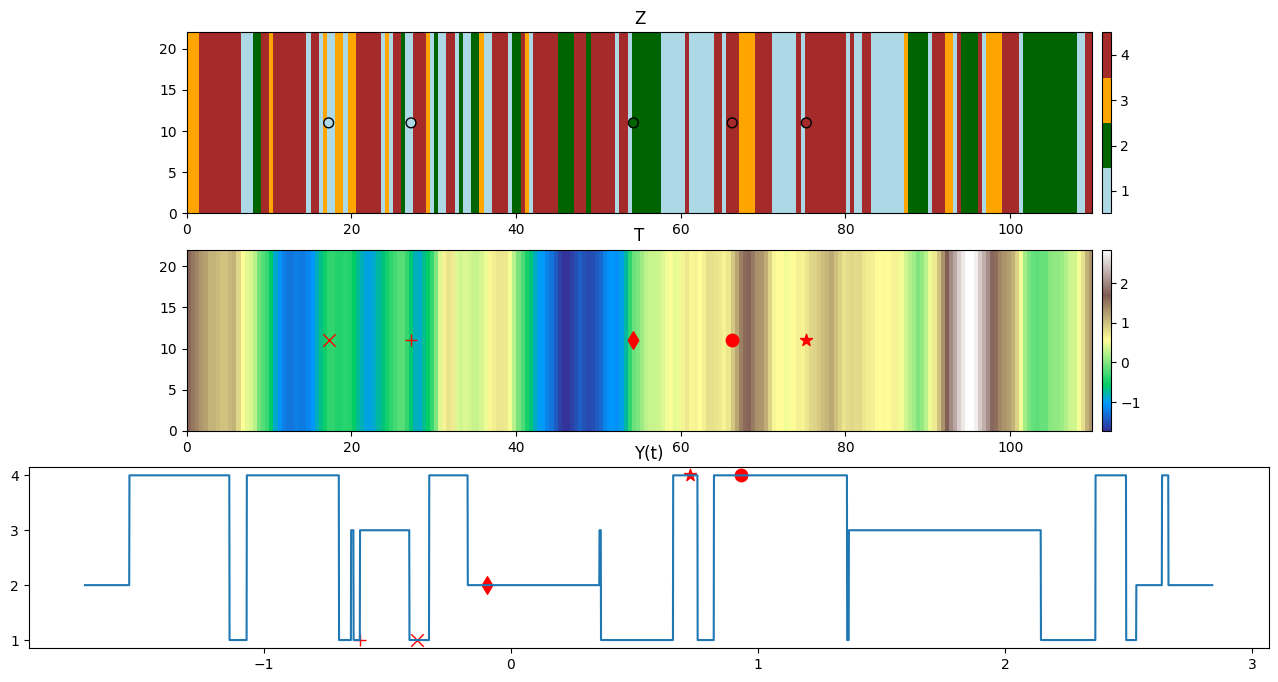

In [6]:
# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_T.sy = .2 * im_T.sx*im_T.nx 
im_Z.sy = .2 * im_Z.sx*im_Z.nx 

# Plot results 
# ------------
ireal = 0 # realization to plot

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

plt.subplots(3, 1, figsize=(16, 8))

# Z
plt.subplot(3,1,1)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    yc = im_Z.oy+0.5*im_Z.sy
    plt.scatter(x, yc*np.ones_like(x), marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)

plt.title('Z')

# T
plt.subplot(3,1,2)
gn.imgplot.drawImage2D(im_T, iv=ireal, **im_T_display)
# Add conditioning location
if x is not None:
    yc = im_T.oy+0.5*im_T.sy
    # plt.plot(x, yc*np.ones_like(x), 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i], yc, marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T')

# Y
plt.subplot(3,1,3)

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:]-im_T.ox)/im_T.sx # (x[:,0]-im_T.oy)/im_T.sy
    jy = np.zeros(x.shape[0])   # (x[:,1]-im_T.oy)/im_T.sy
    jz = np.zeros(x.shape[0])   # (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()

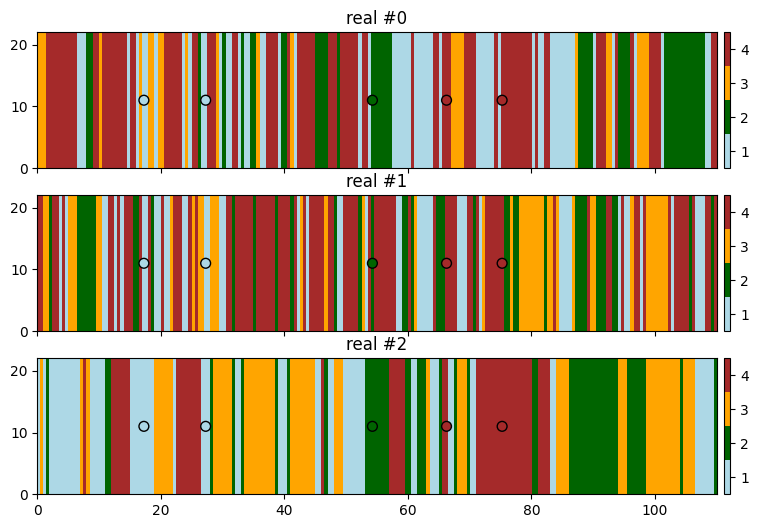

In [7]:
# Plot 3 realizations of Z
plt.subplots(3,1, sharex=True, sharey=True, figsize=(15,6))
plt.subplot(3,1,1)
for j in range(3):
    plt.subplot(3,1,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
        yc = im_Z.oy+0.5*im_Z.sy
        plt.scatter(x, yc*np.ones_like(x), marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 100 realizations (same setup)

In [8]:
# Number of realizations and seed
nreal = 100
seed_sim = 232

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, nx, sx, ox,
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx, 0., 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

srf_mg_mc: simulation 1 of 100...
srf_mg_mc: simulation 2 of 100...
srf_mg_mc: simulation 3 of 100...
srf_mg_mc: simulation 4 of 100...
srf_mg_mc: simulation 5 of 100...
srf_mg_mc: simulation 6 of 100...
srf_mg_mc: simulation 7 of 100...
srf_mg_mc: simulation 8 of 100...
srf_mg_mc: simulation 9 of 100...
srf_mg_mc: simulation 10 of 100...
srf_mg_mc: simulation 11 of 100...
srf_mg_mc: simulation 12 of 100...
srf_mg_mc: simulation 13 of 100...
srf_mg_mc: simulation 14 of 100...
srf_mg_mc: simulation 15 of 100...
srf_mg_mc: simulation 16 of 100...
srf_mg_mc: simulation 17 of 100...
srf_mg_mc: simulation 18 of 100...
srf_mg_mc: simulation 19 of 100...
srf_mg_mc: simulation 20 of 100...
srf_mg_mc: simulation 21 of 100...
srf_mg_mc: simulation 22 of 100...
srf_mg_mc: simulation 23 of 100...
srf_mg_mc: simulation 24 of 100...
srf_mg_mc: simulation 25 of 100...
srf_mg_mc: simulation 26 of 100...
srf_mg_mc: simulation 27 of 100...
srf_mg_mc: simulation 28 of 100...
srf_mg_mc: simulation 29 of 1

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/srf.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  mh_quotient = p_new/p


srf_mg_mc: simulation 31 of 100...
srf_mg_mc: simulation 32 of 100...
srf_mg_mc: simulation 33 of 100...
srf_mg_mc: simulation 34 of 100...
srf_mg_mc: simulation 35 of 100...
srf_mg_mc: simulation 36 of 100...
srf_mg_mc: simulation 37 of 100...
srf_mg_mc: simulation 38 of 100...
srf_mg_mc: simulation 39 of 100...
srf_mg_mc: simulation 40 of 100...
srf_mg_mc: simulation 41 of 100...
srf_mg_mc: simulation 42 of 100...
srf_mg_mc: simulation 43 of 100...
srf_mg_mc: simulation 44 of 100...
srf_mg_mc: simulation 45 of 100...
srf_mg_mc: simulation 46 of 100...
srf_mg_mc: simulation 47 of 100...
srf_mg_mc: simulation 48 of 100...
srf_mg_mc: simulation 49 of 100...
srf_mg_mc: simulation 50 of 100...
srf_mg_mc: simulation 51 of 100...
srf_mg_mc: simulation 52 of 100...
srf_mg_mc: simulation 53 of 100...
srf_mg_mc: simulation 54 of 100...
srf_mg_mc: simulation 55 of 100...
srf_mg_mc: simulation 56 of 100...
srf_mg_mc: simulation 57 of 100...
srf_mg_mc: simulation 58 of 100...
srf_mg_mc: simulatio

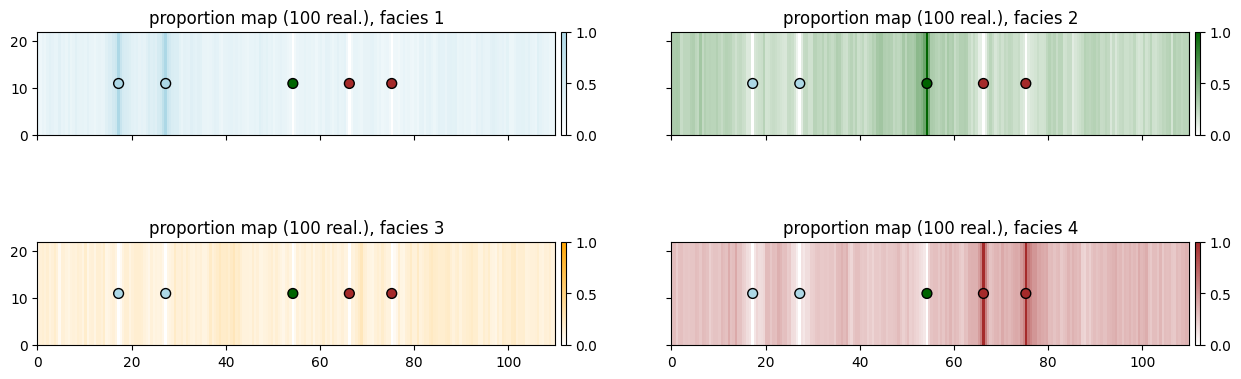

In [9]:
# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_Z.sy = .2 * im_Z.sx*im_Z.nx 

# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot
# ----
plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,5))
plt.subplot(2,2,1)
for j in range(4):
    plt.subplot(2,2,j+1)
    gn.imgplot.drawImage2D(im_Z_stats, iv=j, cmap=cmap[j], vmin=0, vmax=1)
    if x is not None:
        yc = im_Z.oy+0.5*im_Z.sy
        plt.scatter(x, yc*np.ones_like(x), marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'proportion map ({im_Z.nv} real.), facies {categVal[j]}')

plt.show()

## Example : conditional 2D SRF

In [10]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']
im_T_display={'cmap':'terrain'}
im_Z_display={'categ':True, 'categVal':categVal, 'categCol':categCol}

In [11]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------
r_T = 1.0*np.array([25.0, 25.0])
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T, r) for r in r_T]), 'nu':nu_T}),
    ], alpha=0.0, name='cov_model_T')

# Mean of T
mean_T = 0.0

# Markov chain Y
# --------------
# Transition kernel
p = 0.995
kernel_Y = gn.markovChain.mc_kernel1(ncat, p)  # (see function)

# 1D-grid resolution for Y (coding process)
spacing_Y=.001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
##
##
#np.random.seed(123)
#nhd = 30
#x = np.array((ox + np.random.random(nhd)*nx*sx, oy + np.random.random(nhd)*ny*sy)).T
#v = np.random.choice(categVal, replace=True, size=nhd)
#v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)

# Additional constraint on Y (control points)
t_constraint = None
yt_constraint = None

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


srf_mg_mc: simulation 1 of 3...
srf_mg_mc:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mc:   ... sim 1 of 3

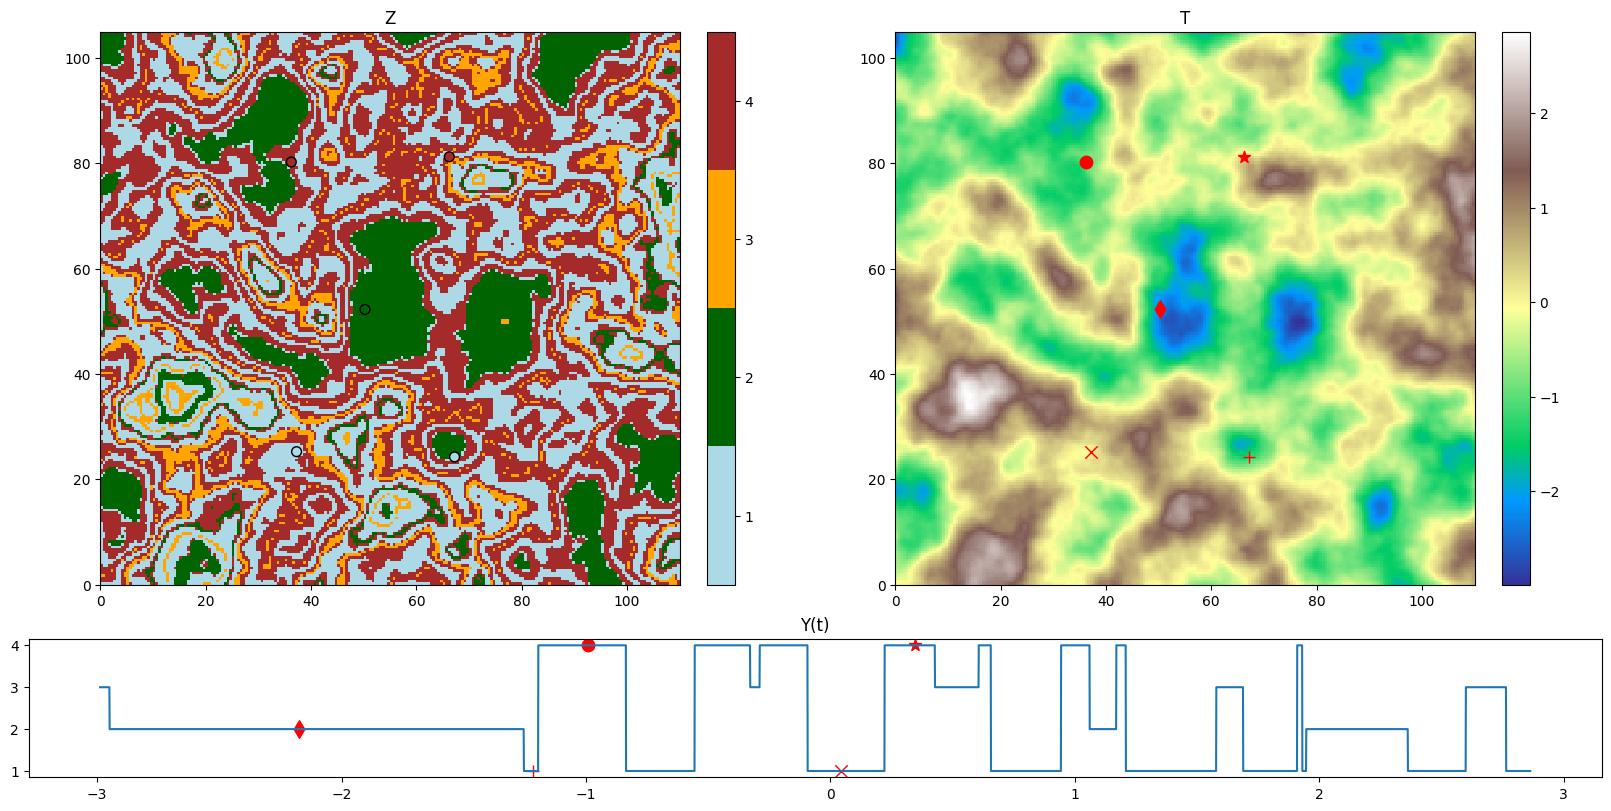

In [12]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = GridSpec(5, 4, figure=fig)
axZ = fig.add_subplot(gs[0:4, 0:2]) # ax for Z
axT = fig.add_subplot(gs[0:4, 2:4]) # ax for T
axY = fig.add_subplot(gs[4:5, 0:4]) # ax for Y

# Z
plt.sca(axZ)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)

plt.title('Z')

# T
plt.sca(axT)
gn.imgplot.drawImage2D(im_T, iv=ireal, **im_T_display)
# Add conditioning location
if x is not None:
    yc = im_T.oy+0.5*im_T.sy
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T')

# Y
plt.sca(axY)

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:,0]-im_T.oy)/im_T.sy
    jy = (x[:,1]-im_T.oy)/im_T.sy
    jz = np.zeros(x.shape[0])   # (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()

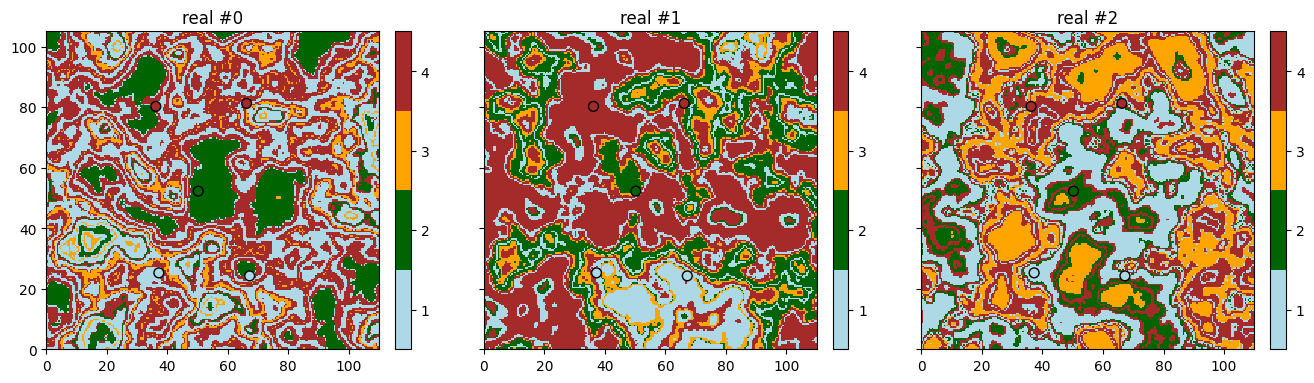

In [13]:
# Plot 3 realizations of Z
plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
plt.subplot(1,3,1)
for j in range(3):
    plt.subplot(1,3,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
        plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 100 realizations (same setup)

In [14]:
# Number of realizations and seed
nreal = 100
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

srf_mg_mc: simulation 1 of 100...
srf_mg_mc: simulation 2 of 100...
srf_mg_mc: simulation 3 of 100...
srf_mg_mc: simulation 4 of 100...
srf_mg_mc: simulation 5 of 100...
srf_mg_mc: simulation 6 of 100...
srf_mg_mc: simulation 7 of 100...
srf_mg_mc: simulation 8 of 100...
srf_mg_mc: simulation 9 of 100...
srf_mg_mc: simulation 10 of 100...
srf_mg_mc: simulation 11 of 100...
srf_mg_mc: simulation 12 of 100...
srf_mg_mc: simulation 13 of 100...
srf_mg_mc: simulation 14 of 100...
srf_mg_mc: simulation 15 of 100...
srf_mg_mc: simulation 16 of 100...
srf_mg_mc: simulation 17 of 100...
srf_mg_mc: simulation 18 of 100...
srf_mg_mc: simulation 19 of 100...
srf_mg_mc: simulation 20 of 100...
srf_mg_mc: simulation 21 of 100...
srf_mg_mc: simulation 22 of 100...
srf_mg_mc: simulation 23 of 100...
srf_mg_mc: simulation 24 of 100...
srf_mg_mc: simulation 25 of 100...
srf_mg_mc: simulation 26 of 100...
srf_mg_mc: simulation 27 of 100...
srf_mg_mc: simulation 28 of 100...
srf_mg_mc: simulation 29 of 1

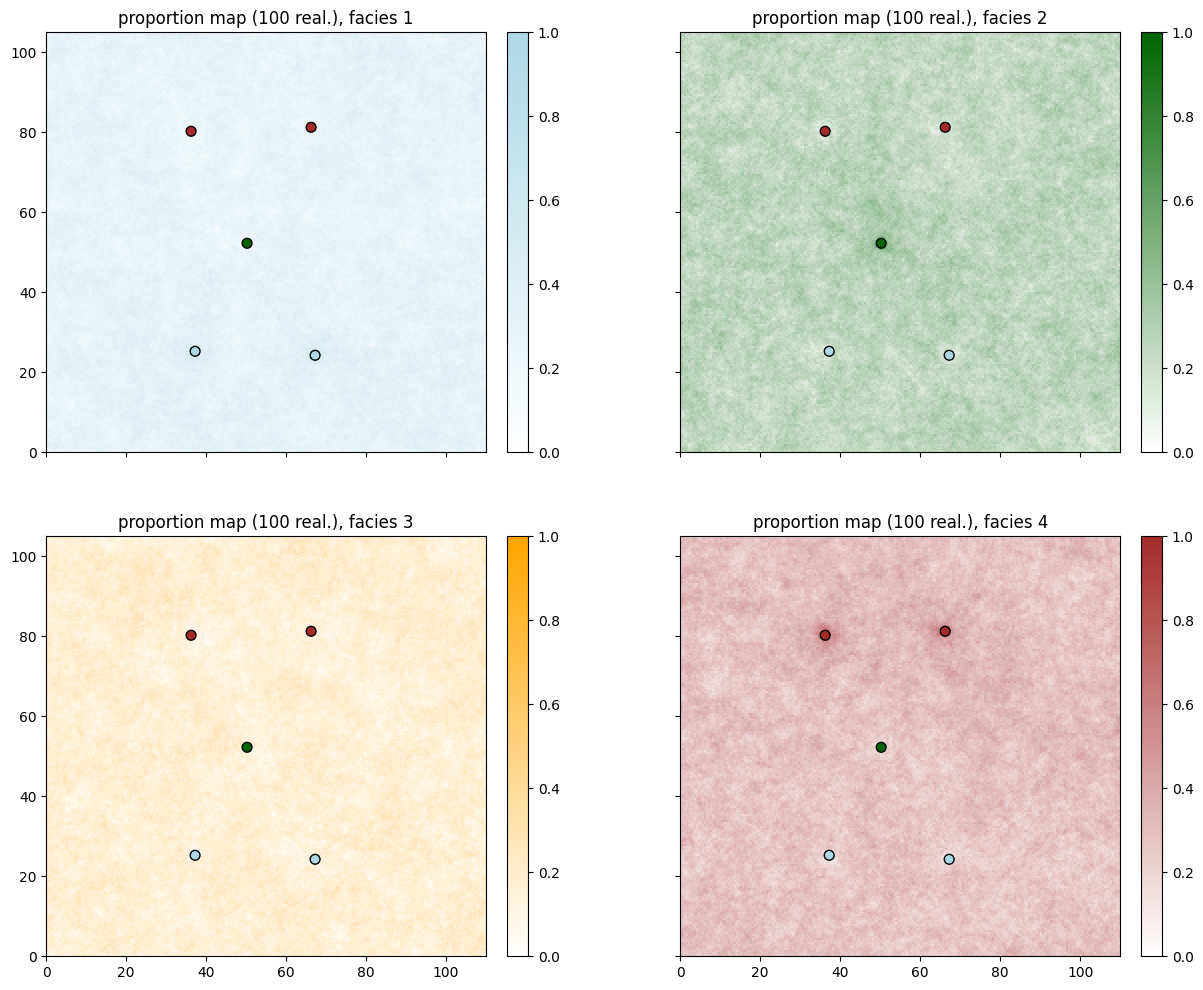

In [15]:
# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot
# ----
plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,12))
plt.subplot(2,2,1)
for j in range(4):
    plt.subplot(2,2,j+1)
    gn.imgplot.drawImage2D(im_Z_stats, iv=j, cmap=cmap[j], vmin=0, vmax=1)
    if x is not None:
        plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'proportion map ({im_Z.nv} real.), facies {categVal[j]}')

plt.show()

## Example : conditional 2D SRF with control point: Y(mean_T) imposed

In [16]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']
im_T_display={'cmap':'terrain'}
im_Z_display={'categ':True, 'categVal':categVal, 'categCol':categCol}

In [17]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------
r_T = 1.0*np.array([25.0, 25.0])
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T, r) for r in r_T]), 'nu':nu_T}),
    ], alpha=0.0, name='cov_model_T')

# Mean of T
mean_T = 0.0

# Markov chain Y
# --------------
# Transition kernel
p = 0.995
kernel_Y = gn.markovChain.mc_kernel1(ncat, p)  # (see function)

# 1D-grid resolution for Y (coding process)
spacing_Y=.001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
##
##
#np.random.seed(123)
#nhd = 30
#x = np.array((ox + np.random.random(nhd)*nx*sx, oy + np.random.random(nhd)*ny*sy)).T
#v = np.random.choice(categVal, replace=True, size=nhd)
#v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)

# Additional constraint on Y (control points)
t_constraint = mean_T
yt_constraint = 4 # one of the categories

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


srf_mg_mc: simulation 1 of 3...
srf_mg_mc:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mc:   ... sim 1 of 3

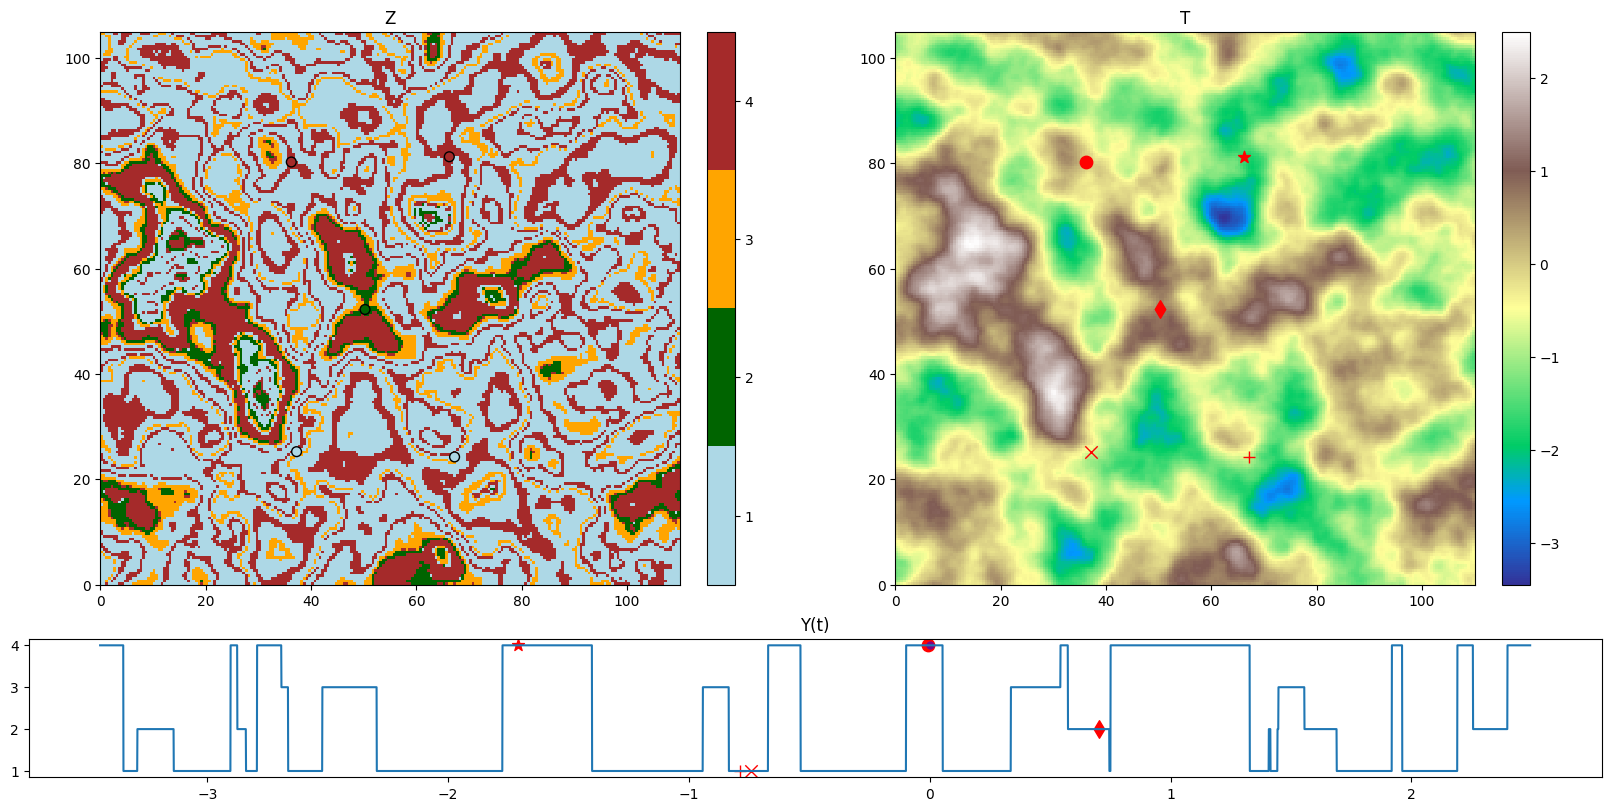

In [18]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = GridSpec(5, 4, figure=fig)
axZ = fig.add_subplot(gs[0:4, 0:2]) # ax for Z
axT = fig.add_subplot(gs[0:4, 2:4]) # ax for T
axY = fig.add_subplot(gs[4:5, 0:4]) # ax for Y

# Z
plt.sca(axZ)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)

plt.title('Z')

# T
plt.sca(axT)
gn.imgplot.drawImage2D(im_T, iv=ireal, **im_T_display)
# Add conditioning location
if x is not None:
    yc = im_T.oy+0.5*im_T.sy
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T')

# Y
plt.sca(axY)

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:,0]-im_T.oy)/im_T.sy
    jy = (x[:,1]-im_T.oy)/im_T.sy
    jz = np.zeros(x.shape[0])   # (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()

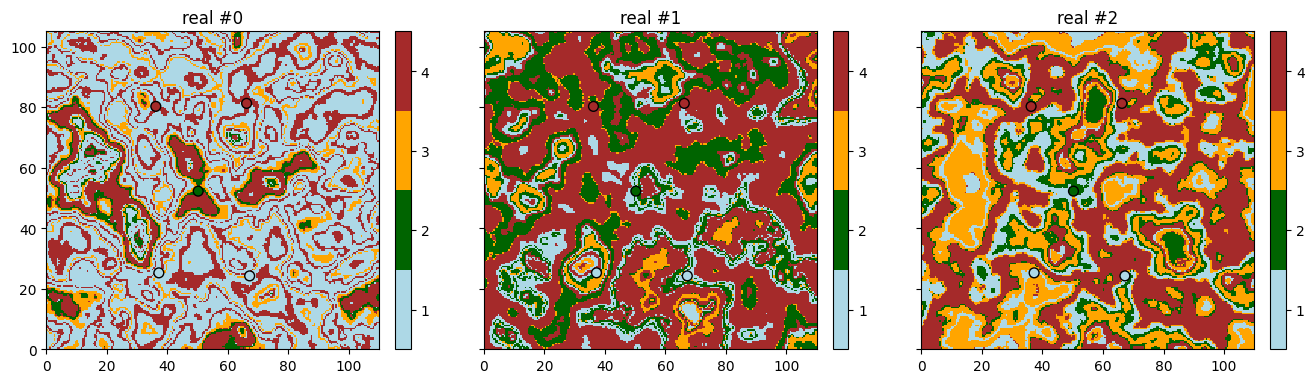

In [19]:
# Plot 3 realizations of Z
plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
plt.subplot(1,3,1)
for j in range(3):
    plt.subplot(1,3,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
        plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 100 realizations (same setup)

In [20]:
# Number of realizations and seed
nreal = 100
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

srf_mg_mc: simulation 1 of 100...
srf_mg_mc: simulation 2 of 100...
srf_mg_mc: simulation 3 of 100...
srf_mg_mc: simulation 4 of 100...
srf_mg_mc: simulation 5 of 100...
srf_mg_mc: simulation 6 of 100...
srf_mg_mc: simulation 7 of 100...
srf_mg_mc: simulation 8 of 100...
srf_mg_mc: simulation 9 of 100...
srf_mg_mc: simulation 10 of 100...
srf_mg_mc: simulation 11 of 100...
srf_mg_mc: simulation 12 of 100...
srf_mg_mc: simulation 13 of 100...
srf_mg_mc: simulation 14 of 100...
srf_mg_mc: simulation 15 of 100...
srf_mg_mc: simulation 16 of 100...
srf_mg_mc: simulation 17 of 100...
srf_mg_mc: simulation 18 of 100...
srf_mg_mc: simulation 19 of 100...
srf_mg_mc: simulation 20 of 100...
srf_mg_mc: simulation 21 of 100...
srf_mg_mc: simulation 22 of 100...
srf_mg_mc: simulation 23 of 100...
srf_mg_mc: simulation 24 of 100...
srf_mg_mc: simulation 25 of 100...
srf_mg_mc: simulation 26 of 100...
srf_mg_mc: simulation 27 of 100...
srf_mg_mc: simulation 28 of 100...
srf_mg_mc: simulation 29 of 1

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/srf.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  mh_quotient = p_new/p


srf_mg_mc: simulation 69 of 100...
srf_mg_mc: simulation 70 of 100...
srf_mg_mc: simulation 71 of 100...
srf_mg_mc: simulation 72 of 100...
srf_mg_mc: simulation 73 of 100...
srf_mg_mc: simulation 74 of 100...
srf_mg_mc: simulation 75 of 100...
srf_mg_mc: simulation 76 of 100...
srf_mg_mc: simulation 77 of 100...
srf_mg_mc: simulation 78 of 100...
srf_mg_mc: simulation 79 of 100...
srf_mg_mc: simulation 80 of 100...
srf_mg_mc: simulation 81 of 100...
srf_mg_mc: simulation 82 of 100...
srf_mg_mc: simulation 83 of 100...
srf_mg_mc: simulation 84 of 100...
srf_mg_mc: simulation 85 of 100...
srf_mg_mc: simulation 86 of 100...
srf_mg_mc: simulation 87 of 100...
srf_mg_mc: simulation 88 of 100...
srf_mg_mc: simulation 89 of 100...
srf_mg_mc: simulation 90 of 100...
srf_mg_mc: simulation 91 of 100...
srf_mg_mc: simulation 92 of 100...
srf_mg_mc: simulation 93 of 100...
srf_mg_mc: simulation 94 of 100...
srf_mg_mc: simulation 95 of 100...
srf_mg_mc: simulation 96 of 100...
srf_mg_mc: simulatio

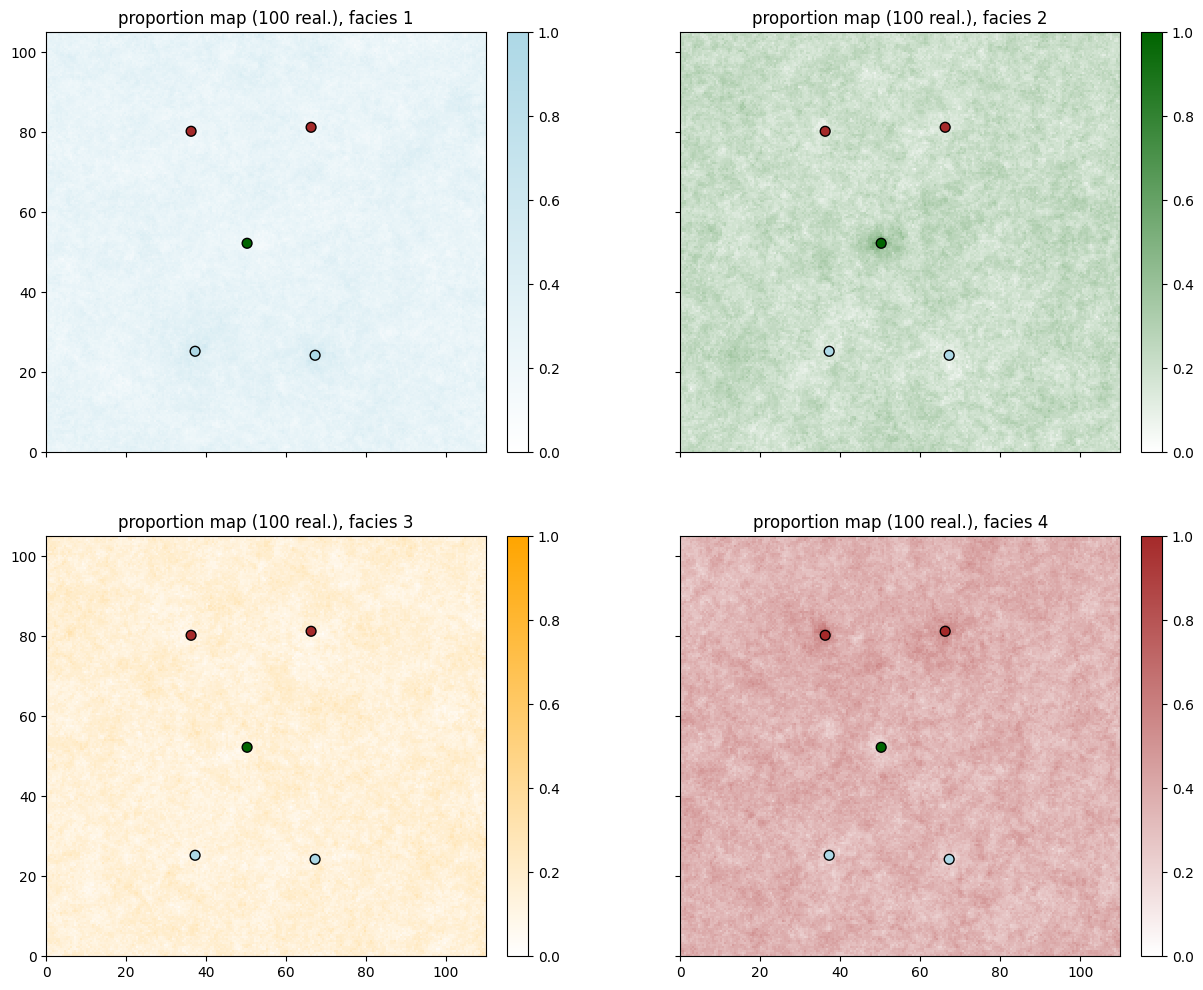

In [21]:
# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot
# ----
plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,12))
plt.subplot(2,2,1)
for j in range(4):
    plt.subplot(2,2,j+1)
    gn.imgplot.drawImage2D(im_Z_stats, iv=j, cmap=cmap[j], vmin=0, vmax=1)
    if x is not None:
        plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'proportion map ({im_Z.nv} real.), facies {categVal[j]}')

plt.show()

## Example : conditional 3D SRF

In [22]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']

In [23]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 120, 110, 55     # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------
r_T = 1.0*np.array([40.0, 30.0, 15.0])
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel3D(elem=[
    ('matern', {'w':w_T, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T, r) for r in r_T]), 'nu':nu_T}),
    ], alpha=0.0, name='cov_model_T')

# Mean of T
mean_T = 0.0

# Markov chain Y
# --------------
# Transition kernel
p = 0.995
kernel_Y = gn.markovChain.mc_kernel1(ncat, p)  # (see function)

# 1D-grid resolution for Y (coding process)
spacing_Y=.001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([[17.25, 15.25, 15.5],
              [47.25, 14.25, 23.5],
              [31.25, 32.25, 10.5],
              [18.25, 49.25, 20.5],
              [46.25, 48.25, 40.5]])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)

# Additional constraint on Y (control points)
t_constraint = None
yt_constraint = None

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')# Fill image


/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


srf_mg_mc: simulation 1 of 3...
srf_mg_mc:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mc:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mc:   ... sim 1 of 3

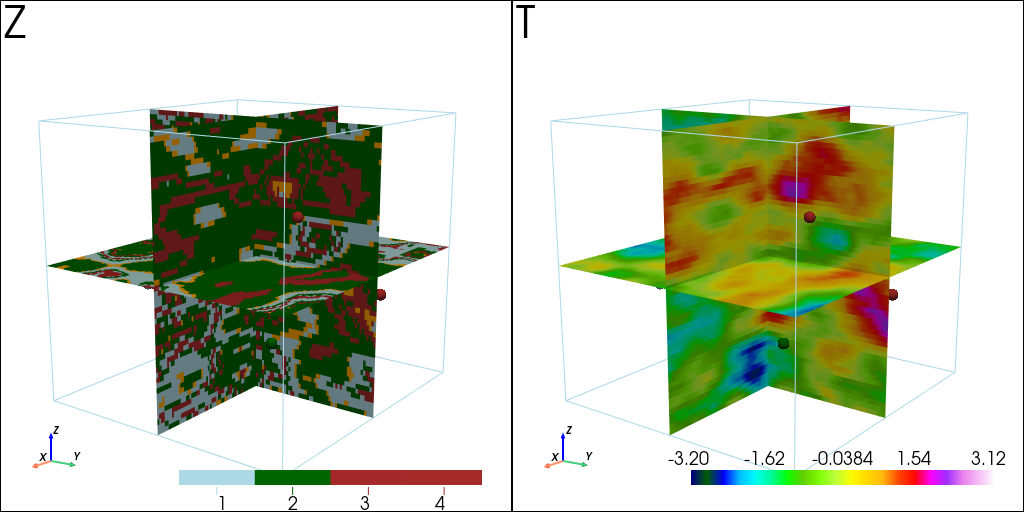

In [24]:
# Plot Z and T for one real
# -------------------------
ireal = 0 # index of the realization

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2), window_size=(1024, 512))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)
    # ... set color for data points according to their value
    data_points_col = [matplotlib.colors.to_rgb(
        categCol[np.where(np.asarray(categVal) == i)[0][0]]) for i in v] 
        # color for data points according to their value
    # or:
    #data_points_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)

    data_points['colors'] = data_points_col

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    im_Z, 
    plotter=pp,
    iv = ireal,
    slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
    slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
    slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
    categ=True, categVal=categVal, categCol=categCol,
    text='Z',
    scalar_bar_kwargs={'title':'', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_T, 
    plotter=pp,
    iv = ireal,
    slice_normal_x=im_T.ox+0.5*im_T.nx*im_T.sx,
    slice_normal_y=im_T.oy+0.5*im_T.ny*im_T.sy,
    slice_normal_z=im_T.oz+0.5*im_T.nz*im_T.sz,
    cmap='gist_ncar', #**im_T_display,
    text='T',
    scalar_bar_kwargs={'title':' ', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)
# note: distinct title for scalar bar, so that it will be displayed!

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

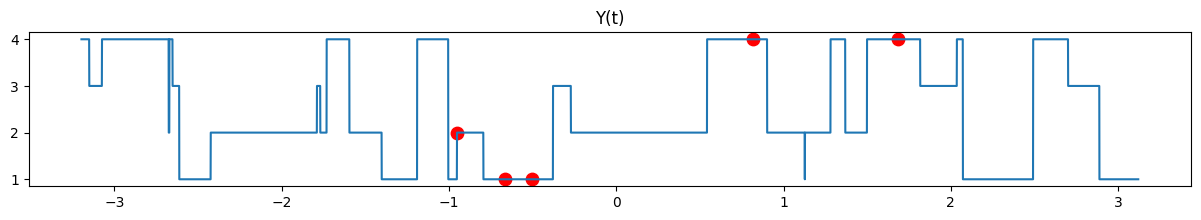

In [25]:
# Plot Y(t)
# ---------
plt.figure(figsize=(15, 2))

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:,0]-im_T.oy)/im_T.sy
    jy = (x[:,1]-im_T.oy)/im_T.sy
    jz = (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker='o', color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()


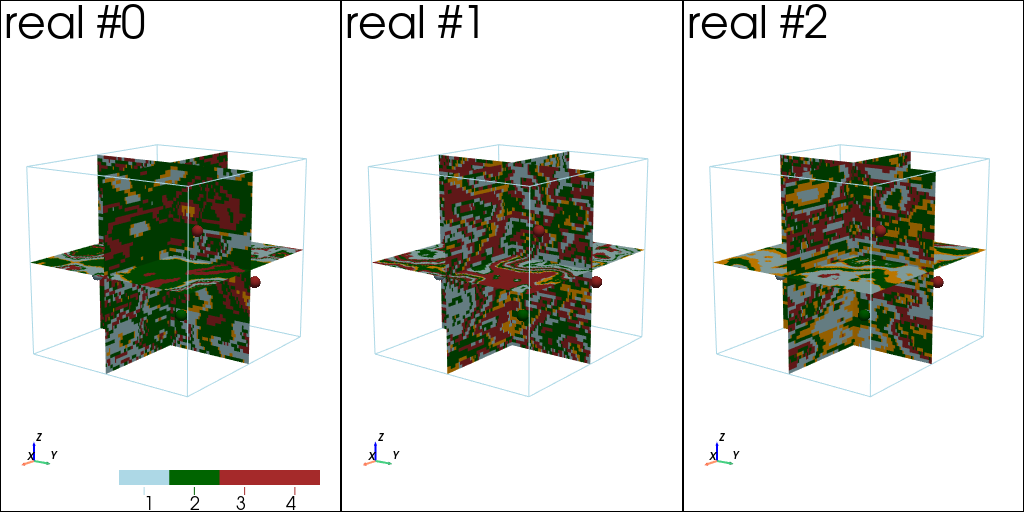

In [26]:
# Plot 3 realizations of Z
# --------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,3), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,3), window_size=(1024, 512))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)
    # ... set color for data points according to their value
    data_points_col = [matplotlib.colors.to_rgb(categCol[np.where(np.asarray(categVal) == i)[0][0]]) for i in v] 
        # color for data points according to their value
    # or:
    #data_points_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
    
    data_points['colors'] = data_points_col

for i in range(3):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        im_Z, iv=i,
        plotter=pp,
        slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
        slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
        slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
        categ=True, categVal=categVal, categCol=categCol,
        text=f'real #{i}',
        scalar_bar_kwargs={'title':'  ', 'title_font_size':20, 'vertical':False})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

### 20 realizations (same setup)

In [27]:
# Number of realizations and seed
nreal = 20
seed_sim = 232

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mc(
    cov_model_T, kernel_Y, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    spacing_Y=spacing_Y,
    categVal=categVal,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    nreal=nreal,
    full_output=False,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')# Fill image


srf_mg_mc: simulation 1 of 20...
srf_mg_mc:   ... sim 1 of 20: MH iter 1 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 2 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 3 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 4 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 5 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 6 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 7 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 8 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 9 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 10 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 11 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 12 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 13 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 14 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 15 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 16 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 17 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 18 of 100...
srf_mg_mc:   ... sim 1 of 20: MH iter 19 of 100...
srf_mg_

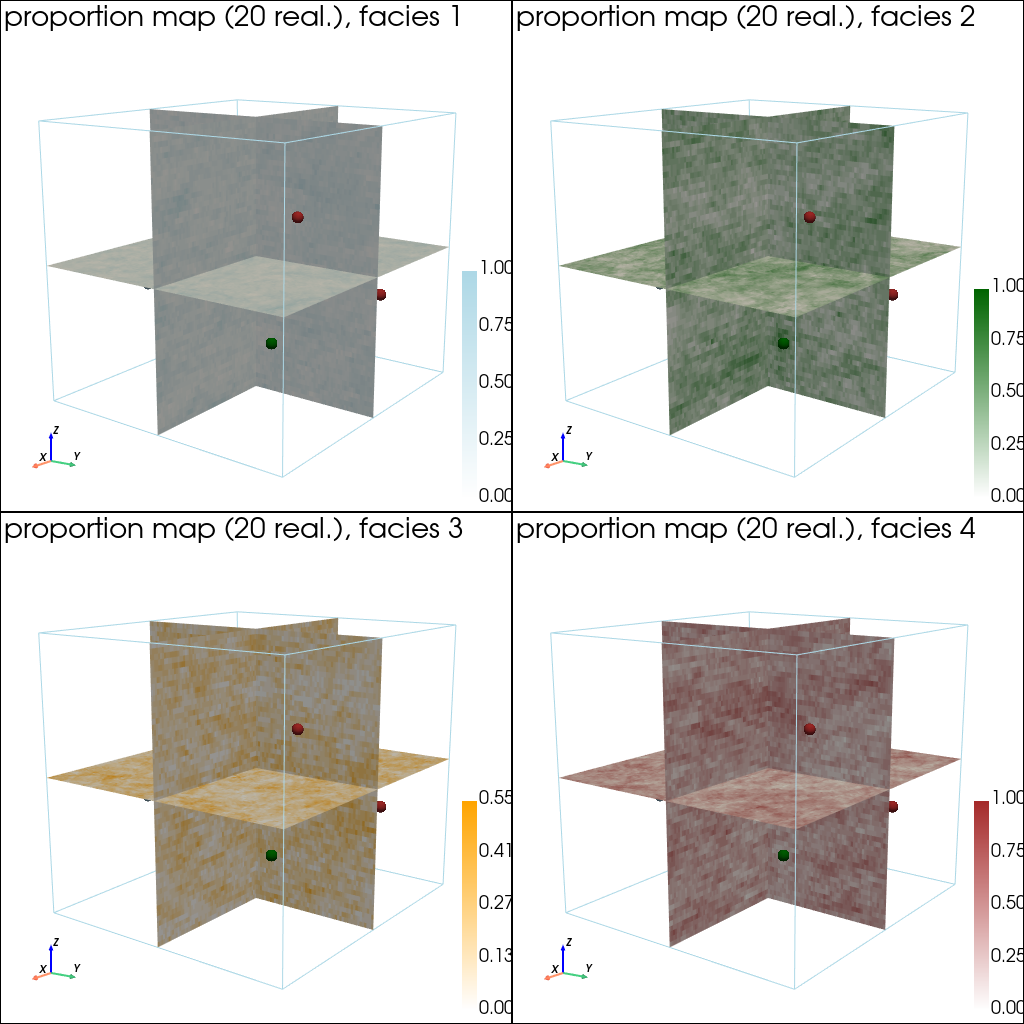

In [28]:
# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot proportion maps
# --------------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2), window_size=(1024, 1024))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)
    # ... set color for data points according to their value
    data_points_col = [matplotlib.colors.to_rgb(
        categCol[np.where(np.asarray(categVal) == i)[0][0]]) for i in v] 
        # color for data points according to their value
    # or:
    #data_points_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
    
    data_points['colors'] = data_points_col

for j in range(4):
    pp.subplot(j//2, j%2)
    gn.imgplot3d.drawImage3D_slice(
        im_Z_stats, iv=j,
        plotter=pp,
        slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
        slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
        slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
        cmap=cmap[j], 
        text=f'proportion map ({im_Z.nv} real.), facies {categVal[j]}',
        scalar_bar_kwargs={'title':j*' ', 'title_font_size':20, 'vertical':True})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified